# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import copy
import math
import random
import time
from collections import deque,namedtuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import progressbar as pb
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from unityagents import UnityEnvironment
from apex import amp

%matplotlib inline

In [2]:
# check which device is being used.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device)

using device:  cuda:0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, num_hidden1=256, num_hidden2=128):
        super(Actor, self).__init__()
        
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return torch.tanh(self.fc2(x))


In [4]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, num_hidden1=256, num_hidden2=128):
        super(Critic, self).__init__()

        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, num_hidden1)
        self.fc2 = nn.Linear(num_hidden1 + action_size, num_hidden2)
        self.fc3 = nn.Linear(num_hidden2, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x) 


In [5]:
class DDPGAgentParams():
    def __init__(
        self, 
        buffer_size=int(1e6), 
        batch_size=512, 
        actor_lr = 1e-5, 
        critic_lr = 1e-4, 
        gamma = .99, 
        tau = 1e-3,
        critic_weight_decay=0,
        noise_sigma=0.2,
        seed=123):
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.tau = tau
        self.critic_weight_decay = critic_weight_decay
        self.noise_sigma = noise_sigma
        self.seed = seed


In [6]:
class DDPGAgent():
    def __init__(self, state_size, action_size, params, device="cpu"):
        self.params = params
        self.device = device
        self.seed = random.seed(params.seed)
        
        self.actor_local = Actor(state_size, action_size, params.seed).to(device)
        self.actor_target = Actor(state_size, action_size, params.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=params.actor_lr)

        self.critic_local = Critic(state_size, action_size, params.seed).to(device)
        self.critic_target = Critic(state_size, action_size, params.seed).to(device)
        self.critic_loss = nn.MSELoss()
        self.critic_optimizer = optim.Adam(
            self.critic_local.parameters(), 
            lr=params.critic_lr, 
            weight_decay=params.critic_weight_decay)
        
        self.memory = ReplayBuffer(params.buffer_size, params.batch_size, params.seed)
        self.n_step = 0

    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.n_step += 1
        if len(self.memory) > self.params.batch_size and self.n_step % 20 == 0:
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences)
            

    def to_float_tensor(self, ndarray):
        return torch.from_numpy(ndarray).float().to(self.device)
    
    def to_numpy(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def act(self, state, add_noise=True):
        state_tensor = self.to_float_tensor(state)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.to_numpy(self.actor_local(state_tensor))
        
        self.actor_local.train()
        
        if add_noise:
            action += np.random.normal(scale=self.params.noise_sigma)

        return np.clip(action, -1, 1)

    def reset(self):
        pass
      
    
    def learn(self, experiences):
        states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor = experiences
        gamma = self.params.gamma
        
        # Q Target (with target network)
        actions_next_tensor = self.actor_target(next_states_tensor)
        Q_targets_next = self.critic_target(next_states_tensor, actions_next_tensor)
        Q_targets = rewards_tensor + (gamma * Q_targets_next * (1 - dones_tensor))

        # Q Expected (with local network)
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = self.critic_loss(Q_expected, Q_targets)
        
        # Optimize Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # Actor loss
        actions_tensor = self.actor_local(states_tensor)
        actor_loss = -self.critic_local(states_tensor, actions_tensor).mean()

        # Optimize Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update
        self.soft_update(self.critic_local, self.critic_target, self.params.tau)
        self.soft_update(self.actor_local, self.actor_target, self.params.tau)             
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", "state, action, reward, next_state, done")
        
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e =self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        n = min(self.batch_size, len(self.memory))
        experiences = random.sample(self.memory, k=n)
        
        states = torch.from_numpy(np.array([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences])).float().to(device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 2.48
Episode 200	Average Score: 9.50
Episode 300	Average Score: 15.02
Episode 400	Average Score: 18.27
Episode 500	Average Score: 23.34
Episode 600	Average Score: 23.82
Episode 700	Average Score: 27.37
Episode 800	Average Score: 31.41
Episode 900	Average Score: 34.22
Episode 1000	Average Score: 36.45


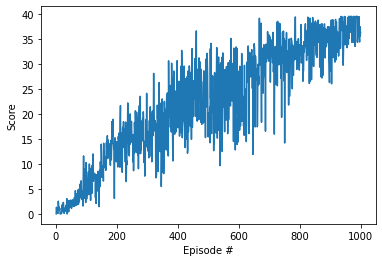

In [9]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

states = env_info.vector_observations
state_size = states.shape[1]
action_size = brain.vector_action_space_size

params = DDPGAgentParams()
agent = DDPGAgent(state_size, action_size, params, device=device)

# agent.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))


episode = 1000

def step(env, action):
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    return next_state, reward, done

scores_deque = deque(maxlen=100)
max_t = 1000
scores = []
for i in range(1, episode+1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    agent.reset()
    score = 0
    for _ in range(max_t):
        action = agent.act(state)
        next_state, reward, done = step(env, action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
            
    scores_deque.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)), end="")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if i % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_deque)))


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
# Danger
# torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_best.pth')
# torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_best.pth')


In [8]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]

states = env_info.vector_observations
state_size = states.shape[1]
action_size = brain.vector_action_space_size

params = DDPGAgentParams()
agent = DDPGAgent(state_size, action_size, params, device=device)


agent.actor_local.load_state_dict(torch.load('checkpoint_actor_best.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_best.pth'))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


<All keys matched successfully>

In [13]:

def step(env, action):
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    return next_state, reward, done


max_t = 200

for _ in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    agent.reset()

    score = 0
    for i in range(max_t):
        action = agent.act(state, add_noise=False)
        next_state, reward, done = step(env, action)
        state = next_state
        score += reward
        print('\r{}, Score: {:.2f}'.format(i, score), end="")
        _
        if done:
            break 

    print('\r{}, Score: {:.2f}'.format(i, score))



199, Score: 7.50
199, Score: 7.17
199, Score: 7.56
199, Score: 7.28
199, Score: 6.64
199, Score: 6.68
199, Score: 7.39
199, Score: 6.38
199, Score: 7.16
199, Score: 7.47
